# Deep Learning CA1 Part A Submission

**Student Name:** Irman Zafyree Bin Irmanizam

**Class:** DAAA/FT/2B/21

**Admin Number:** P2300546

# Background
## Objective
Build image classification models to recognise 15 types of vegetables. There are two input size given, 37 x 37 pixels and 131 x 131 pixels, thus 2 models must be made. The images must be converted to grayscale for both of the models. Once the models are builts and trained, compare and discuss the accuracies of both models.

## Task (Verbose)
Implement an image classifier using a deep learning network. You are given colour
images of 224 by 224 pixels, containing 15 types of vegetables.

You must convert the given images into grayscale (i.e. only 1 channel instead of 3).
Consider two different input sizes:

a) 37 by 37 pixels

b) 131 by 131 pixels

Do not use the original size of 224 by 224 pixels.

Build two types of neural networks, one for each input size. Compare and discuss the
classification accuracies for each input size

# Importing Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import functions as cnnf

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import EarlyStopping

# Imbalanced Learn Libraries
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## Other Preparation

In [2]:
# Fixing random seed
seed = 999
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(tf.config.experimental.get_device_details(gpu))
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPUs")

{'device_name': 'NVIDIA GeForce RTX 3090', 'compute_capability': (8, 6)}
There are 1 GPUs


# Data Preparation

Even before we prep the data, we should do a general obersvation at the images in the data.
From the train data, we can that in the beans folder, there are **Carrots**. Hence, we should probably remove that before we let our model be trained of it. Besides just that, we can also see in some of the images, it is the bean alone, while some are taken with other beans, or vegetable in the markets. In some images, there are also a hand holding the bean.

In [4]:
dataset_path = "./Dataset_PartA/Dataset for CA1 part A - AY2425S1"

train_folder = os.path.join(dataset_path,"train")
test_folder = os.path.join(dataset_path,"test")
validation_folder = os.path.join(dataset_path,"validation")

# These are the paths of the train, test, and validation folders for the dataset

In [5]:
train_vege_count = pd.DataFrame(columns=["Name", "Count"])
test_vege_count = pd.DataFrame(columns=["Name", "Count"])
validation_vege_count = pd.DataFrame(columns=["Name", "Count"])

def pop_vege_count(data_folder, vege_count):
    for folder in os.listdir(data_folder):
        count = len(os.listdir(os.path.join(data_folder, folder)))
        vege_count.loc[folder] = [folder,count]

pop_vege_count(train_folder, train_vege_count)
pop_vege_count(test_folder, test_vege_count)
pop_vege_count(validation_folder, validation_vege_count)

print(f"Train Data\n{train_vege_count}\n\n")

print(f"Test Data\n{test_vege_count}\n\n")

print(f"Validation Data\n{validation_vege_count}\n\n")

Train Data
                      Name  Count
Bean                  Bean    784
Bitter_Gourd  Bitter_Gourd    720
Bottle_Gourd  Bottle_Gourd    441
Brinjal            Brinjal    868
Broccoli          Broccoli    750
Cabbage            Cabbage    503
Capsicum          Capsicum    351
Carrot              Carrot    256
Cauliflower    Cauliflower    587
Cucumber          Cucumber    812
Papaya              Papaya    566
Potato              Potato    377
Pumpkin            Pumpkin    814
Radish              Radish    248
Tomato              Tomato    955


Test Data
                      Name  Count
Bean                  Bean    200
Bitter_Gourd  Bitter_Gourd    200
Bottle_Gourd  Bottle_Gourd    200
Brinjal            Brinjal    200
Broccoli          Broccoli    200
Cabbage            Cabbage    200
Capsicum          Capsicum    200
Carrot              Carrot    200
Cauliflower    Cauliflower    200
Cucumber          Cucumber    200
Papaya              Papaya    200
Potato              Potat

### Image Preprocessing

#### Grayscaling images

In [6]:
# following guide https://www.tensorflow.org/tutorials/images/classification
# Global Variables
batch_size = None
img_height = 224
img_weight = 224

# making image dataset
# image are converted to grayscale
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    batch_size = batch_size,
    image_size = (img_height, img_weight),
    color_mode = "grayscale",
    seed = seed)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    batch_size = batch_size,
    image_size = (img_height, img_weight),
    color_mode = "grayscale",
    seed = seed)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_folder,
    batch_size = batch_size,
    image_size = (img_height, img_weight),
    color_mode = "grayscale",
    seed = seed)
print(train_dataset.class_names)

Found 9032 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [7]:
# Loading 1 images

for images,labels in train_dataset.take(1):
    img=images.numpy().astype("uint8")
    plt.imshow(img, cmap="gray")

#### Resizing the image & scaling the color scale

In [8]:
# followinh guide https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing
resizing_layer_131 = tf.keras.layers.Resizing(131,131)
resizing_layer_37 = tf.keras.layers.Resizing(37,37)
scaling_layer = tf.keras.layers.Rescaling(1./255)

train_dataset_131 = train_dataset.map(lambda x, y: (resizing_layer_131(x), y))
train_dataset_131_norm = train_dataset_131.map(lambda x, y: (scaling_layer(x), y))

test_dataset_131 = test_dataset.map(lambda x, y: (resizing_layer_131(x), y))
test_dataset_131_norm = test_dataset_131.map(lambda x, y: (scaling_layer(x), y))

validation_dataset_131 = validation_dataset.map(lambda x, y: (resizing_layer_131(x), y))
validation_dataset_131_norm = validation_dataset_131.map(lambda x, y: (scaling_layer(x), y))

train_dataset_37 = train_dataset.map(lambda x, y: (resizing_layer_37(x), y))
train_dataset_37_norm = train_dataset_37.map(lambda x, y: (scaling_layer(x), y))

test_dataset_37 = test_dataset.map(lambda x, y: (resizing_layer_37(x), y))
test_dataset_37_norm = test_dataset_37.map(lambda x, y: (scaling_layer(x), y))

validation_dataset_37 = validation_dataset.map(lambda x, y: (resizing_layer_37(x), y))
validation_dataset_37_norm = validation_dataset_37.map(lambda x, y: (scaling_layer(x), y))

# Background Research & Exploratory Data Analysis

Displaying the images for each class types in each of the respective resolution, 224, 131 & 37

In [9]:
class_names = train_dataset.class_names

### Images (224)

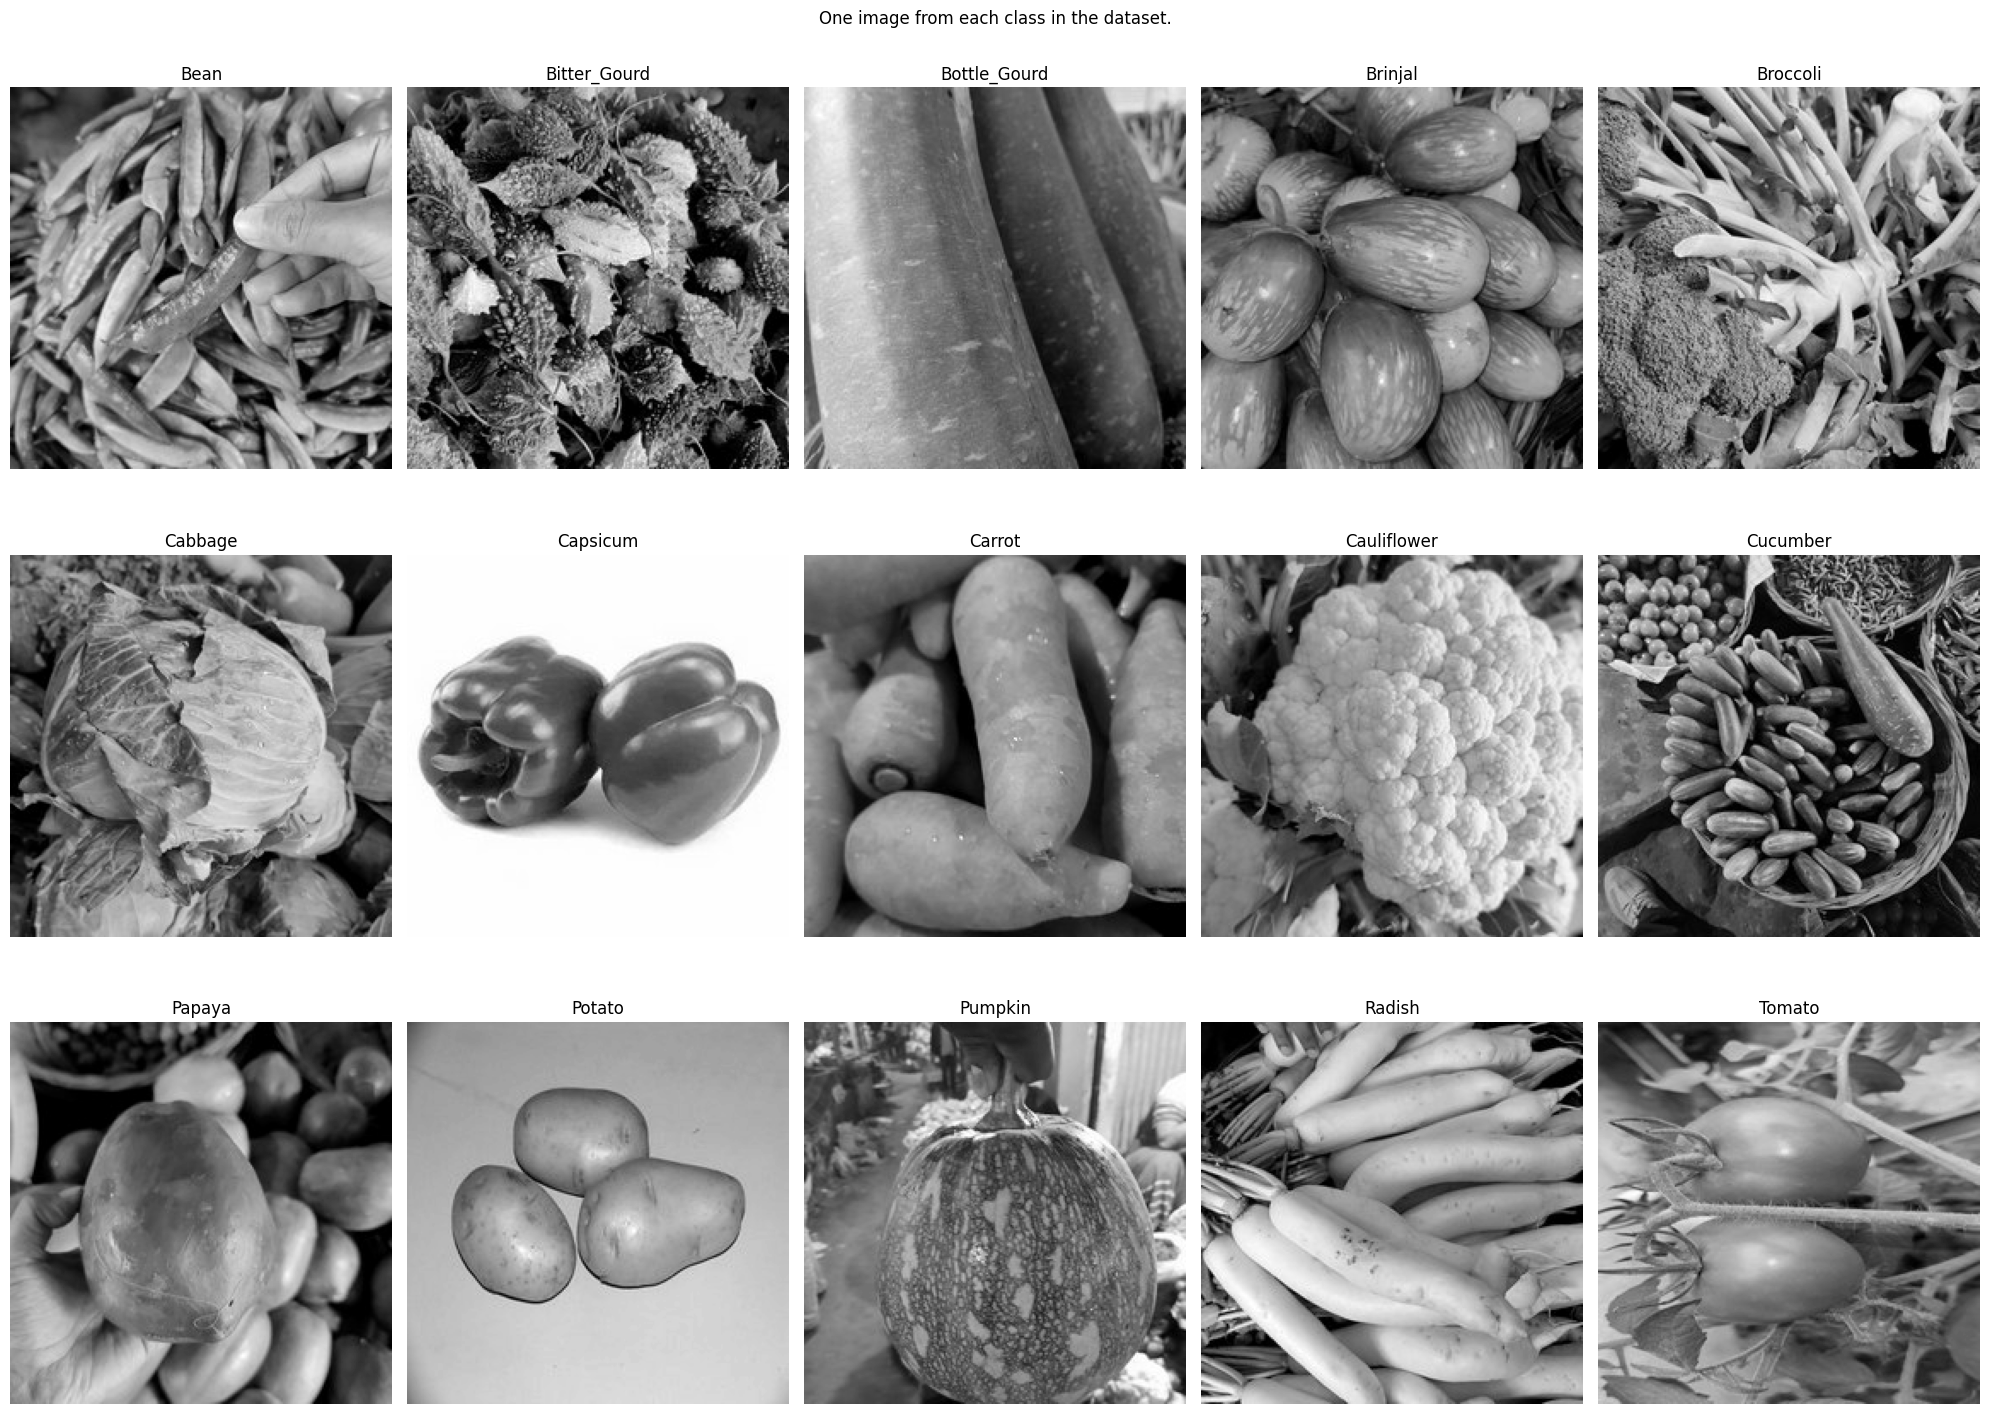

In [10]:
cnnf.class_image(train_dataset,class_names, cmap="gray")

### Images (131)

In [11]:
cnnf.class_image(train_dataset_131,class_names, cmap="gray")

### Images (37)

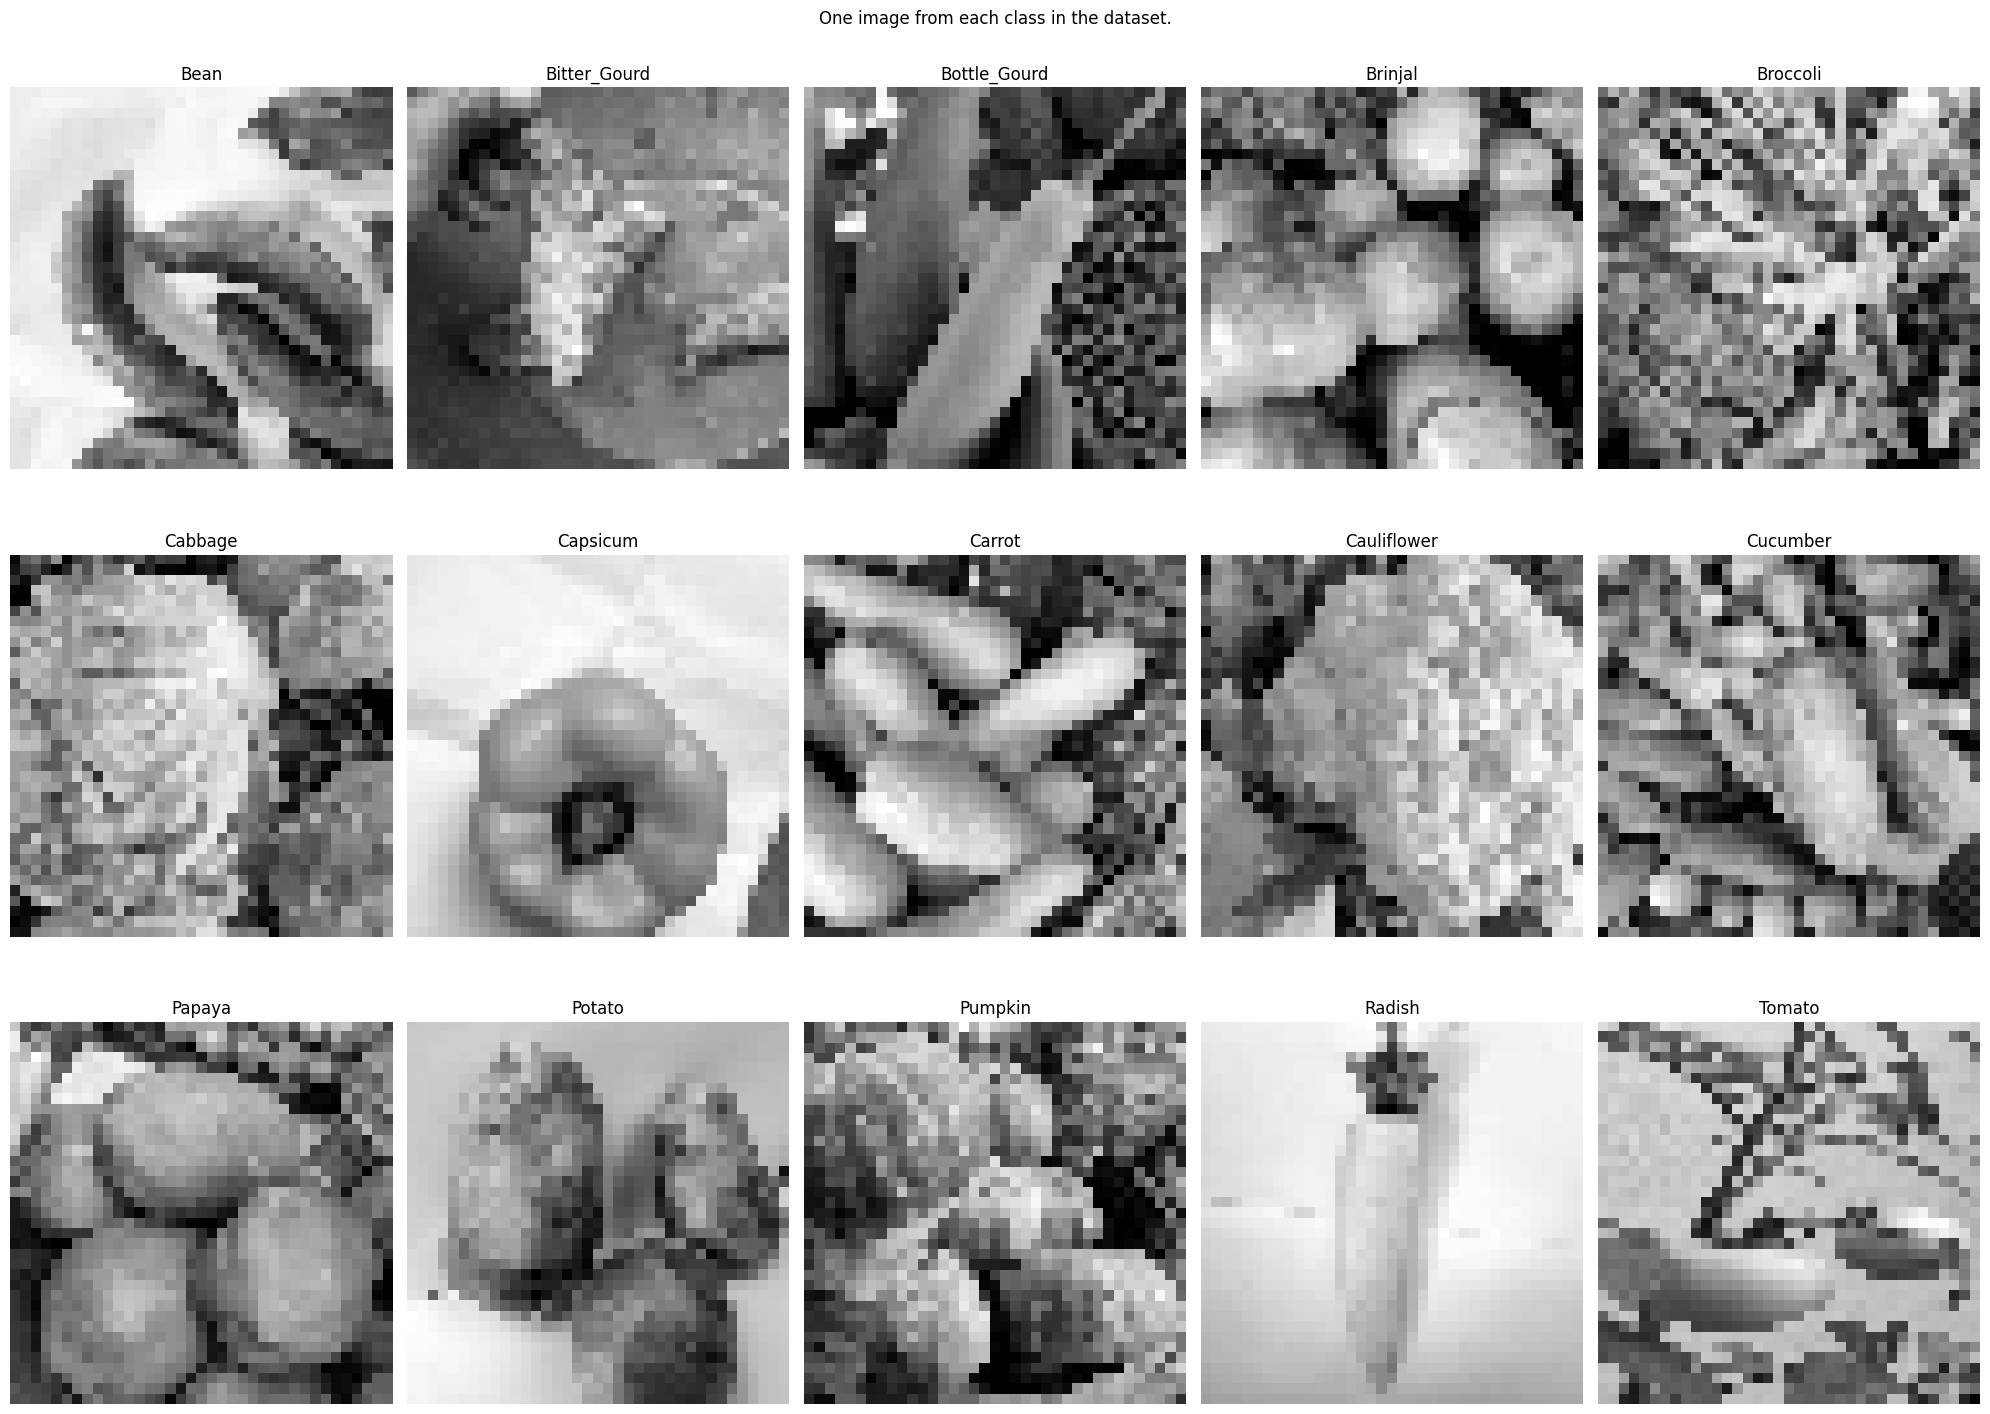

In [12]:
cnnf.class_image(train_dataset_37,class_names, cmap="gray")

From this, we can see that for the 131x131 resolution images, there is still visible edges and shapes that the model can use as features. 

However. for the 37x37 resolution images, it is difficult, for me, to even see the vegetable in some of the images. Especially for the images with other distraction in the background. This will it difficult for the model to identify unique features to each of the vegetables which can affect its accuracy.

### Average (131)

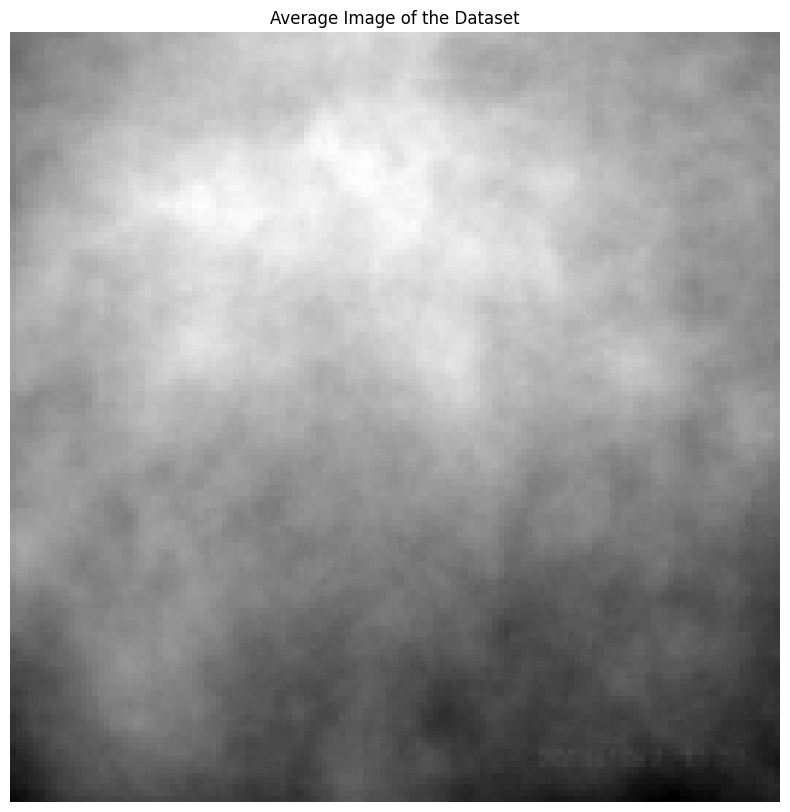

In [13]:
cnnf.average_image(train_dataset_131)

In [14]:
cnnf.average_images_per_class(train_dataset_131,class_names)

### Average (37)

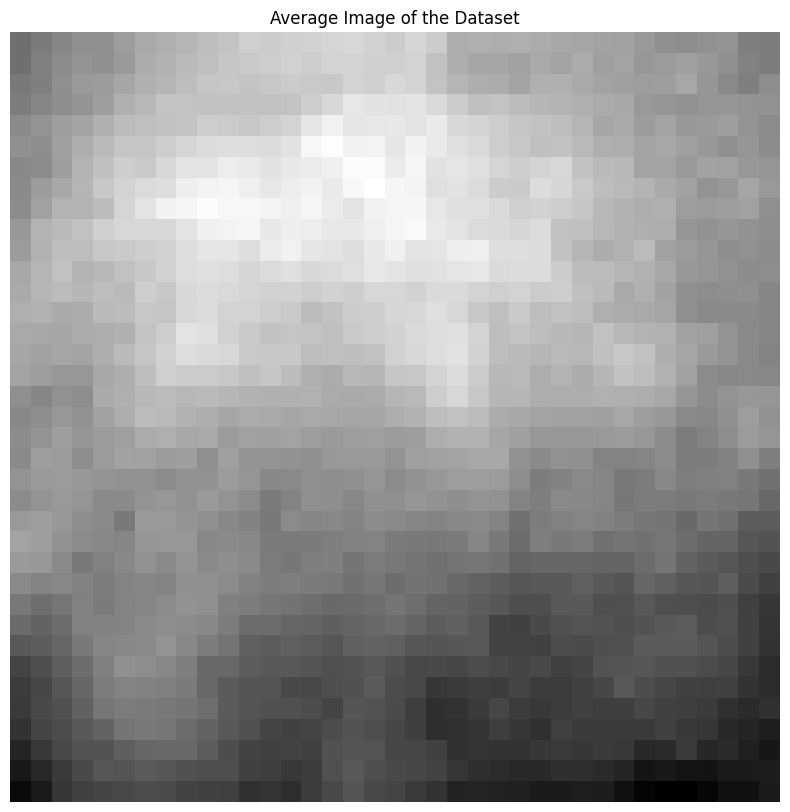

In [15]:
cnnf.average_image(train_dataset_37)

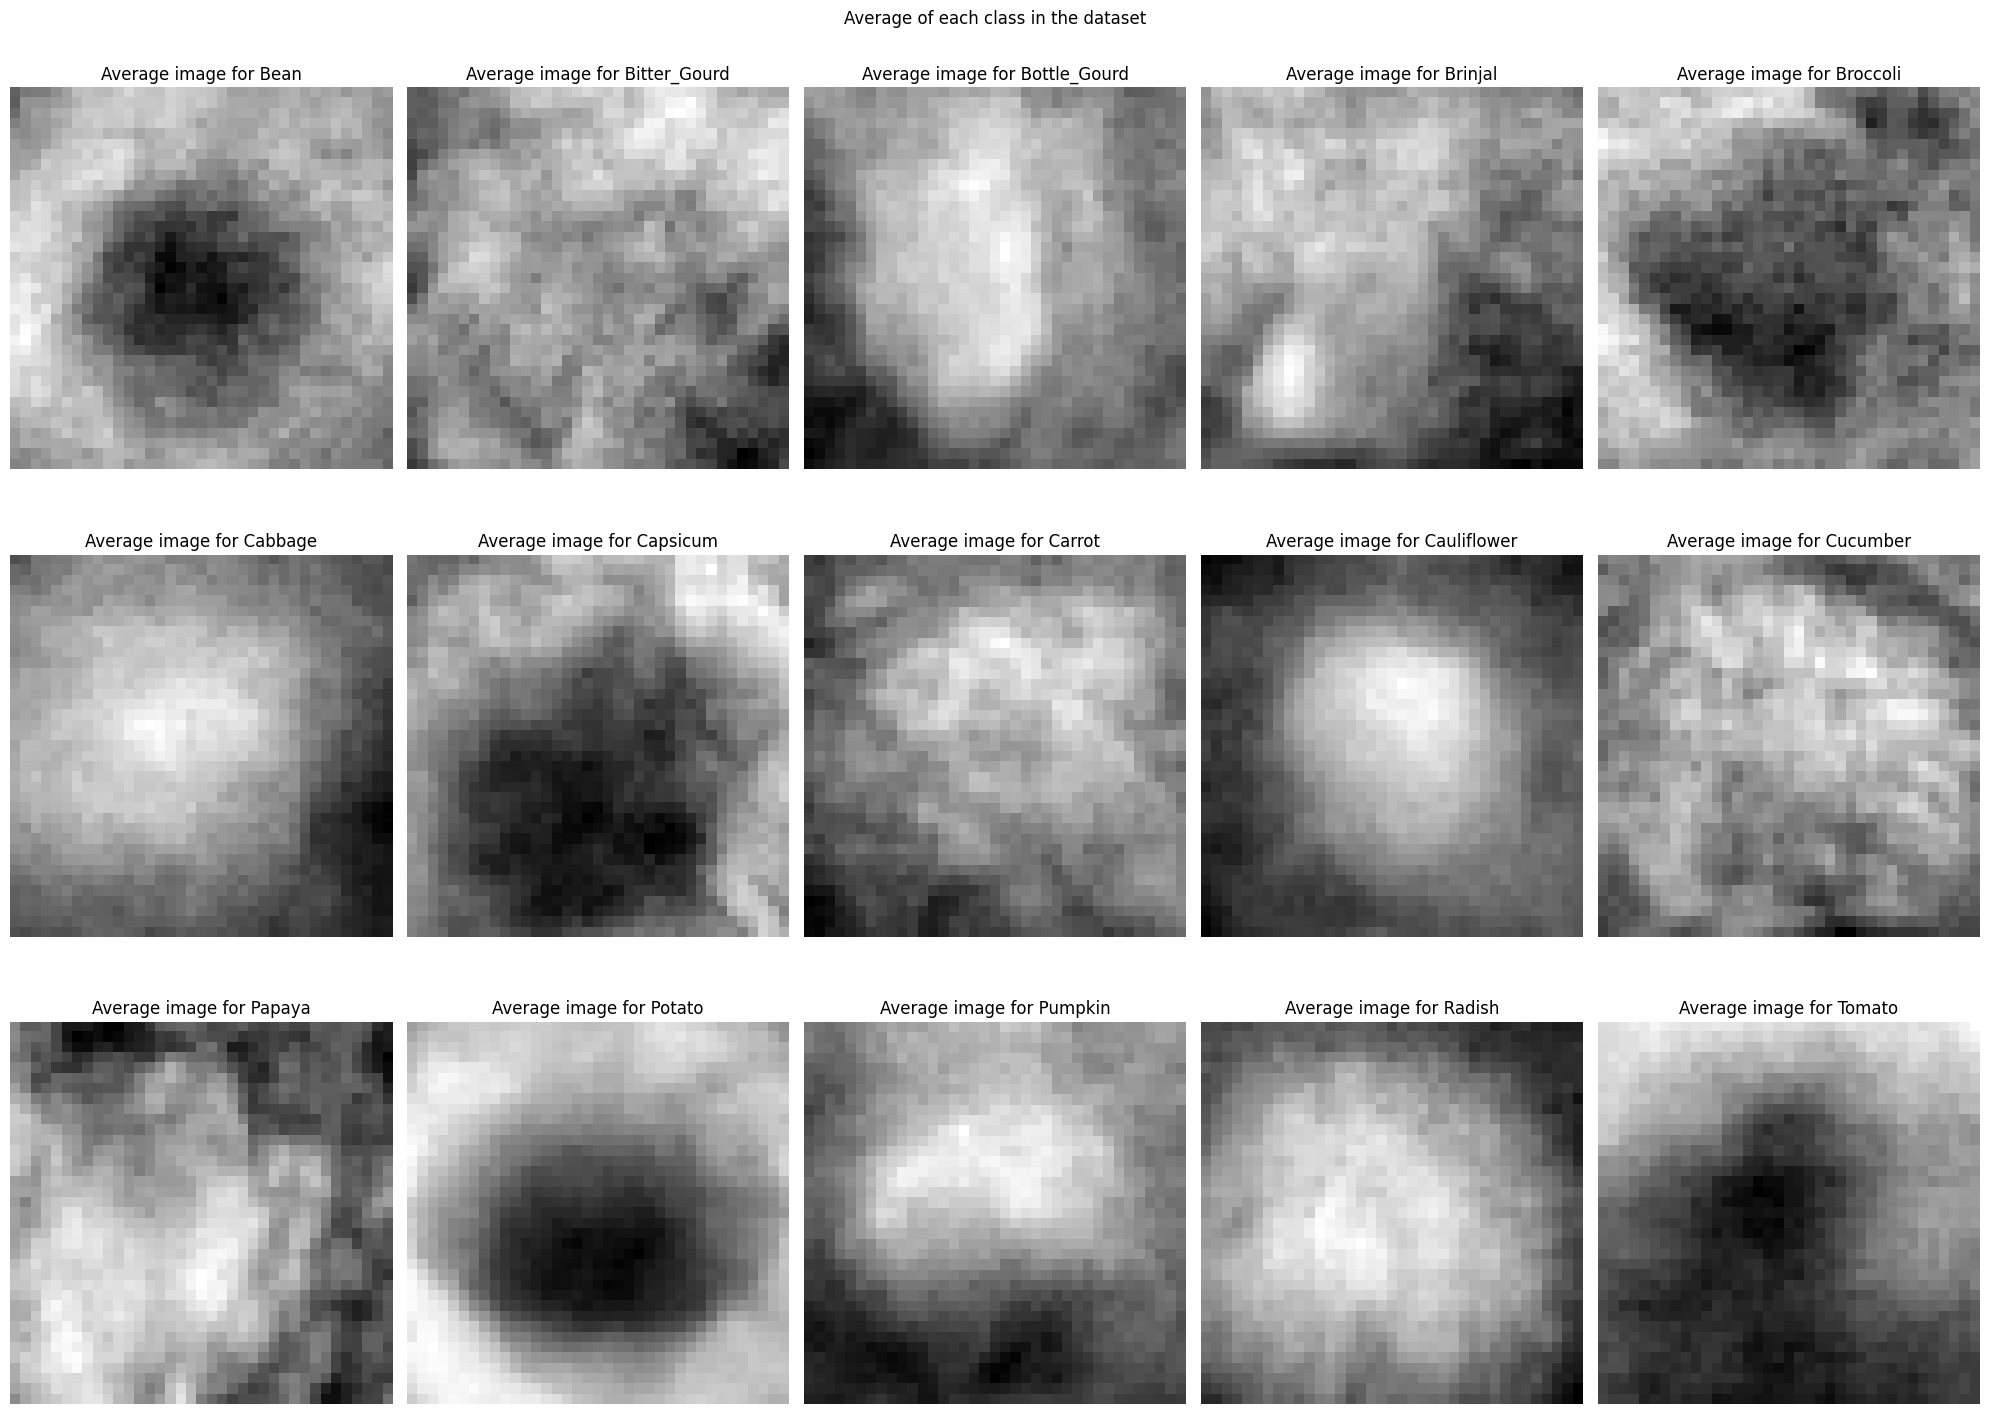

In [16]:
cnnf.average_images_per_class(train_dataset_37,class_names)

From the average pixel values in the images by classes, we can see there are some differences in the vegetables. For vegetables **Bean**, **Capsicum**, **Broccoli**, **Potato** and **Tomato**, there tends to be a darker spot in the center of the images. While for vegetables **Bottle_Gourd**, **Cabbage**, **Cauliflower**, **Papaya**, **Pumpkin** and **Radish**, there tends to be a lighter spot in the center of the images. 

The model might to use these differences as features for its identification. However, we should do more work to the data, to extract as much information as we can given what we have.

# Feature Engineering or Data Augmentation

Firstly, to ensure that what we are doing is positively affecting the accuracy of the model, we need a baseline model to test with.

### Baseline Model

For our baseline models, we should use a simple CNN model, making use of Tensorflow Cov2D layers.

The Cov2D layers are more optimal layers to use than others like Dense as Cov2D uses less parameters, perverse spatial information of the image, and is able to detects features like edges and patterns. This will allow our model to understand the image as a whole rather than as individual pixel values. 

For the loss function, we should use Sparse Categorical Crossentropy. This loss function is better suited for our nature of dataset, which has a large amount of classes. Sparse Categorical Crossentropy is great as it does not require one-hot encoding. Thus, it is more memory efficient than other loss functions like Categorical Crossentropy. This also mean we can skip the one-hot encoding step.

Lastly, for our optimizer, we should we Adam. Adam is generally a recommended optimizer due to its effectiveness and adaptability. Adam has adaptive learning rate, meaning it can adapt the learning rate based on each of the weights in the model. It also combines 2 popular optimizer, RMSProp and Momentum, thus it can deal with non-staionary objectives and sparse gradients, and be able to accelerate the convergence in the relevant direction.

In [17]:
num_classes = len(class_names)

# The baseline_model followss the model from this guide
# https://www.tensorflow.org/tutorials/images/classification#create_the_model
baseline_model = Sequential()
baseline_model.add(Conv2D(16, (3,3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())
baseline_model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())
baseline_model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())
baseline_model.add(Flatten())
baseline_model.add(Dense(128, activation="relu"))
baseline_model.add(Dense(num_classes, activation="softmax"))
baseline_model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [18]:
baseline131_model = clone_model(baseline_model)
baseline37_model = clone_model(baseline_model)

baseline131_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
baseline37_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [19]:
print(type(baseline131_model))

<class 'keras.engine.sequential.Sequential'>


Now we have a baseline model, let create a control experiment, before we make any modifications to the image data or improving the model. We will train the model using the current data. We will plot the accuracy on the training data, and the accuracy on the validation model.

In [20]:
earlyStopper = EarlyStopping(monitor="val_loss", patience=5)
# the patience is the number of epoch of no improvement to the monitored value
# before it stops.

# the start_from_epoch is when the early stopping will actually start monitoring
# and decide when to stop (nevermine it doesnt exist?)

# all the values here are number I pull from the air

#### Batching the datasets


In [21]:
train_dataset_131_norm_b32 = train_dataset_131_norm.batch(32)
test_dataset_131_norm_b32 = test_dataset_131_norm.batch(32)
validation_dataset_131_norm_b32 = validation_dataset_131_norm.batch(32)

train_dataset_37_norm_b32 = train_dataset_37_norm.batch(32)
test_dataset_37_norm_b32 = test_dataset_37_norm.batch(32)
validation_dataset_37_norm_b32 = validation_dataset_37_norm.batch(32)

#### Baseline Results (131)

Epoch 1/150
283/283 [==============================] - 10s 18ms/step - loss: 1.8150 - accuracy: 0.4270 - val_loss: 1.4098 - val_accuracy: 0.5483
Epoch 2/150
283/283 [==============================] - 6s 19ms/step - loss: 0.9602 - accuracy: 0.7003 - val_loss: 1.0853 - val_accuracy: 0.6587
Epoch 3/150
283/283 [==============================] - 6s 19ms/step - loss: 0.5395 - accuracy: 0.8330 - val_loss: 0.8299 - val_accuracy: 0.7507
Epoch 4/150
283/283 [==============================] - 6s 19ms/step - loss: 0.3047 - accuracy: 0.9054 - val_loss: 0.6708 - val_accuracy: 0.8010
Epoch 5/150
283/283 [==============================] - 6s 19ms/step - loss: 0.1628 - accuracy: 0.9511 - val_loss: 0.7448 - val_accuracy: 0.8047
Epoch 6/150
283/283 [==============================] - 6s 19ms/step - loss: 0.1063 - accuracy: 0.9683 - val_loss: 0.6795 - val_accuracy: 0.8280
Epoch 7/150
283/283 [==============================] - 6s 19ms/step - loss: 0.0715 - accuracy: 0.9811 - val_loss: 0.7453 - val_accuracy

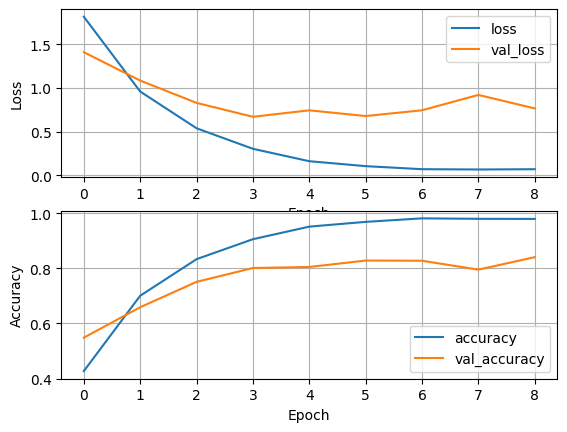

In [22]:
history = baseline131_model.fit(train_dataset_131_norm_b32, validation_data=validation_dataset_131_norm_b32, epochs=150, callbacks=[earlyStopper])
# The epochs is just a number i pull from the air,
# there is a early stopping functions so it wont actually use the whole 150

cnnf.plot_loss_accuracy(history)

#### Baseline Results (37)

Epoch 1/150
283/283 [==============================] - 6s 17ms/step - loss: 2.1963 - accuracy: 0.2802 - val_loss: 1.9481 - val_accuracy: 0.3817
Epoch 2/150
283/283 [==============================] - 5s 16ms/step - loss: 1.5051 - accuracy: 0.5100 - val_loss: 1.4201 - val_accuracy: 0.5250
Epoch 3/150
283/283 [==============================] - 5s 16ms/step - loss: 1.1358 - accuracy: 0.6295 - val_loss: 1.1218 - val_accuracy: 0.6233
Epoch 4/150
283/283 [==============================] - 5s 16ms/step - loss: 0.9174 - accuracy: 0.7069 - val_loss: 1.3139 - val_accuracy: 0.5720
Epoch 5/150
283/283 [==============================] - 5s 16ms/step - loss: 0.7317 - accuracy: 0.7727 - val_loss: 0.8863 - val_accuracy: 0.7140
Epoch 6/150
283/283 [==============================] - 5s 16ms/step - loss: 0.5995 - accuracy: 0.8124 - val_loss: 0.8237 - val_accuracy: 0.7263
Epoch 7/150
283/283 [==============================] - 5s 17ms/step - loss: 0.4989 - accuracy: 0.8468 - val_loss: 0.6790 - val_accuracy:

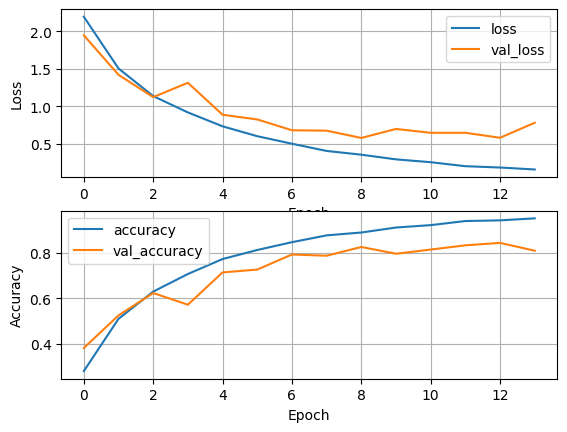

In [23]:
history = baseline37_model.fit(train_dataset_37_norm_b32, validation_data=validation_dataset_37_norm_b32, epochs=150, callbacks=[earlyStopper])
# The epochs is just a number i pull from the air,
# there is a early stopping functions so it wont actually use the whole 150

cnnf.plot_loss_accuracy(history)

We can see that the baseline model performed quite well. Both being able to get an accuracy of over 80% and a loss less than 1.

Now, lets see if we can improve this further by improving on the datasets.

## Number of Images per Class

This should go without saying that it is generally between to have equal number of images in all the classes. Balancing the number can reduce bias, and improve generalization. 

Lets plot the number of images in each of the classes.

In [24]:
def image_class_count_graph(count, title):
    # plt.figure(figsize=(10,5))
    # sns.barplot(x=count["Name"], y=count["Count"])
    # plt.xlabel("Vegetable")
    # plt.ylabel("Count")
    # plt.xticks(rotation=45)
    # plt.title(title)
    # plt.show()

    count_sort = count.sort_values("Count", ascending=False)

    fig,ax = plt.subplots()
    ax.bar(count_sort["Name"], count_sort["Count"])
    ax.set_xlabel("Vegetable")
    ax.set_ylabel("Count")
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

In [25]:
image_class_count_graph(train_vege_count, "Train Data")

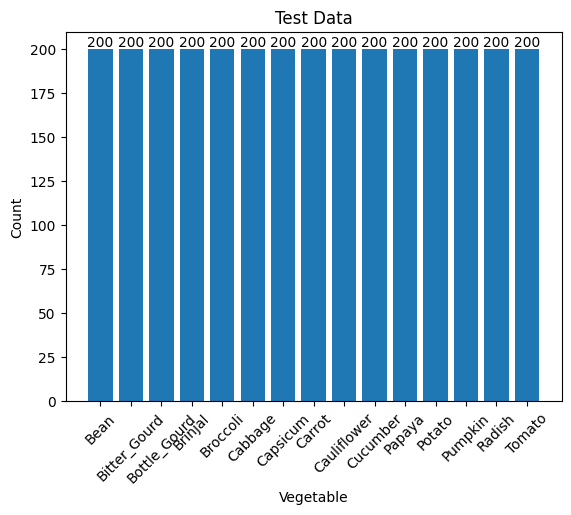

In [26]:
image_class_count_graph(test_vege_count, "Test Data")

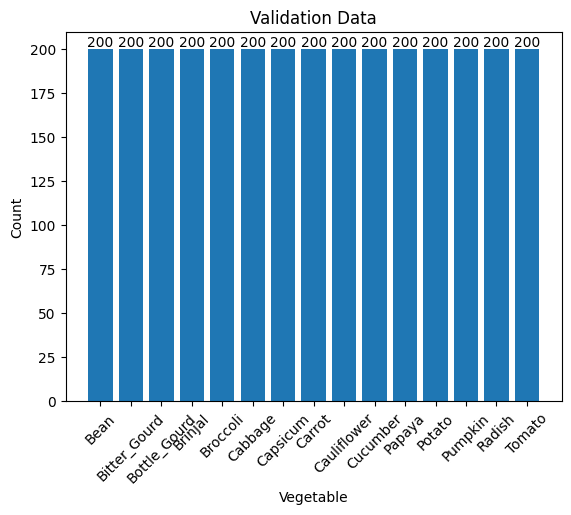

In [27]:
image_class_count_graph(validation_vege_count, "Validation Data")

From here, we can see that the counts for the test and validation datasets are equal. However, the count for the training dataset is not. This could cause the data to be more biased towards tomato and be biased against radish.

There are couple of ways to overcome this issue. We can undersample such that all the data amount is equal to the radish, 248. We could oversample such that all the data is equal to tomata, 955. ORRRR, we can create new data via data augmentation for the data less than 955.

Lets test all 3 methods and see which one has the better results. For sake of simplification, I will train on the 37 res basemodel. However, this assumes that the improves made on the lower res model also means there will be similar improvement on the higher res model.

### Undersampling (37)

In [31]:
image_data = []
labels = []

for image,label in train_dataset.enumerate():
    image_data.append(image.numpy().astype("uint8"))
    labels.append(class_names[label[1].numpy()])

In [34]:
df = pd.DataFrame({
    "Image": image_data,
    "Label": labels
})

# count of each label
print(df["Label"].value_counts())

rus = RandomUnderSampler(random_state=seed)
X_resampled, y_resampled = rus.fit_resample(df["Image"].values.reshape(-1,1), df["Label"])

print(f"Original Data Shape: {df.shape}")

new_df = pd.DataFrame({
    "Image": X_resampled.flatten(),
    "Label": y_resampled
})

print(new_df["Label"].value_counts())


Label
Tomato          955
Brinjal         868
Pumpkin         814
Cucumber        812
Bean            784
Broccoli        750
Bitter_Gourd    720
Cauliflower     587
Papaya          566
Cabbage         503
Bottle_Gourd    441
Potato          377
Capsicum        351
Carrot          256
Radish          248
Name: count, dtype: int64
Original Data Shape: (9032, 2)
Label
Bean            248
Bitter_Gourd    248
Bottle_Gourd    248
Brinjal         248
Broccoli        248
Cabbage         248
Capsicum        248
Carrot          248
Cauliflower     248
Cucumber        248
Papaya          248
Potato          248
Pumpkin         248
Radish          248
Tomato          248
Name: count, dtype: int64
